In [1]:
import sys
sys.path.append('../')
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# os.environ['TORCH_HOME'] = '/home/jovyan/.cache/torch/'
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import visualize
from utils import pickle_load, pickle_save
from utils import get_bdd_paths, get_camvid_paths
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp
# segmentation models wrapper
from segmodel import SegModel
# anomaly detection functions
from anomaly_detection import sample_selection_function
# datasets wrapper
from dataset import CamVid, BDD100K

In [2]:
MAX_QUEERY_IMAGES = 100 # 220 # maximum number of images to train on during AL loop
MODEL_TRAIN_EPOCHS = 1 # 5 # number of epochs to train a model during one AL cicle
BATCH_SIZE = 16
INITIAL_LR = 1e-4
INITIAL_N_TRAIN_IMAGES = 20 # 20, initial number of accessible labelled images
NUM_UNCERTAIN_IMAGES = [20] #, 100] # k: number of uncertain images to label at each AL cicle
SEMSEG_CLASSES = ['road', 'car']
SAMPLES_SELECTIONS = ['Random', 'Committee']

In [3]:
# get the data
X_train_paths, \
y_train_paths, \
X_valid_paths, \
y_valid_paths = get_camvid_paths(DATA_DIR='../data/CamVid/')

In [4]:
def al_experiment(models,
                  k,
                  samples_selection_name='Random',
                  experiment_name='AL_experiment',
                  visualize_most_uncertain=False,
                  verbose_train=False,
                  random_seed=1):
    # tensorboard
    tb = SummaryWriter(log_dir=f'tb_runs/{experiment_name}')
    
    # choose first data batch to train on
    np.random.seed(random_seed)
    X = np.copy(X_train_paths)
    y = np.copy(y_train_paths)
    
    initial_selection = np.random.choice(len(X), INITIAL_N_TRAIN_IMAGES, replace=False) # k
    X_train_paths_part = X[initial_selection]
    y_train_paths_part = y[initial_selection]

    X_test = np.delete(X, initial_selection)
    y_test = np.delete(X, initial_selection)
    
    samples_selection_fn = sample_selection_function(samples_selection_name)
    
    IoUs = [0.]
    N_train_samples = [0]
    # main AL loop
    while len(X_train_paths_part) <= MAX_QUEERY_IMAGES:
        # train each model in committee
        print('Labelled set size: ', len(X_train_paths_part))
        print('Unlabelled set size: ', len(X_test))
        for model in models:
            print(f'\nTraining a model for {model.epochs} epochs...')
            model.train(X_train_paths_part,
                        y_train_paths_part,
                        X_valid_paths,
                        y_valid_paths,
                        Dataset=CamVid,
                        verbose=verbose_train)
        # remeber results
        val_iou = np.max([model.max_val_iou_score for model in models])
        print(f'IoU so far: {val_iou}')
        IoUs.append(val_iou)
        N_train_samples.append(len(X_train_paths_part))

        train_iou = np.max([model.max_train_iou_score for model in models])
        tb.add_scalar('Train IoU vs N train images', train_iou, len(X_train_paths_part))
        tb.add_scalar('Valid IoU vs N train images', val_iou, len(X_train_paths_part))
        
        if len(X_test) < k:
            print('\nNo more images in Unlabelled set')
            break

        # select most uncertain samples
        selected_images_indexes = samples_selection_fn(X_test, k, models)

        # Visualization
        if visualize_most_uncertain:
            print('Visualizing most uncertain results so far:')
            for i in selected_images_indexes[:1]:
                img_path = X_test[i]
                image = cv2.imread(img_path)[...,(2,1,0)]
                for model in models:
                    pr_mask = model.predict([img_path])
                    mask_np = pr_mask.squeeze().cpu().numpy().round()

                    visualize(image=image, road_mask=mask_np[0,...], car_mask=mask_np[1,...])

        # Add labels for uncertain images to train data
        #print('Labelled set before: ', len(X_train_paths_part))
        X_train_paths_part = np.concatenate([X_train_paths_part, X_test[selected_images_indexes]])
        y_train_paths_part = np.concatenate([y_train_paths_part, y_test[selected_images_indexes]])
        #print('Labelled set after: ', len(X_train_paths_part))

        # Remove labelled data from validation set
        #print('Unlabelled set before: ', len(X_test))
        X_test = np.delete(X_test, selected_images_indexes)
        y_test = np.delete(y_test, selected_images_indexes)
        #print('Unlabelled set after: ', len(X_test))

    print(f'Max IoU score: {np.max(IoUs)}')
    print('----------------------------------------\n')
    return IoUs, N_train_samples


Samples selection function: Random
------------------------------------

Number of samples to label on one iteration, k=20
------------------------------------
Labelled set size:  20
Unlabelled set size:  347

Training a model for 1 epochs...
Creating new model: Unet_mobilenet_v2

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:07<00:00, 13.56it/s, dice_loss - 0.5894, iou_score - 0.1711]
Model saved!

Training a model for 1 epochs...
Creating new model: FPN_mobilenet_v2

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:06<00:00, 14.87it/s, dice_loss - 0.5028, iou_score - 0.3373]
Model saved!
IoU so far: 0.3373394992091867
Visualizing most uncertain results so far:


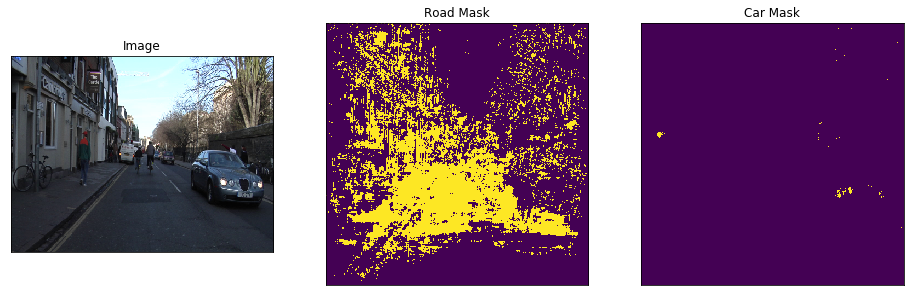

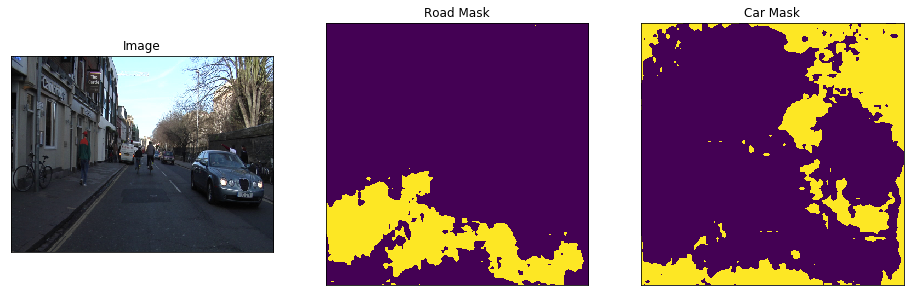

Labelled set size:  40
Unlabelled set size:  327

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:07<00:00, 13.15it/s, dice_loss - 0.5361, iou_score - 0.3197]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:07<00:00, 14.28it/s, dice_loss - 0.2896, iou_score - 0.5586]
Model saved!
IoU so far: 0.5585672696038049
Visualizing most uncertain results so far:


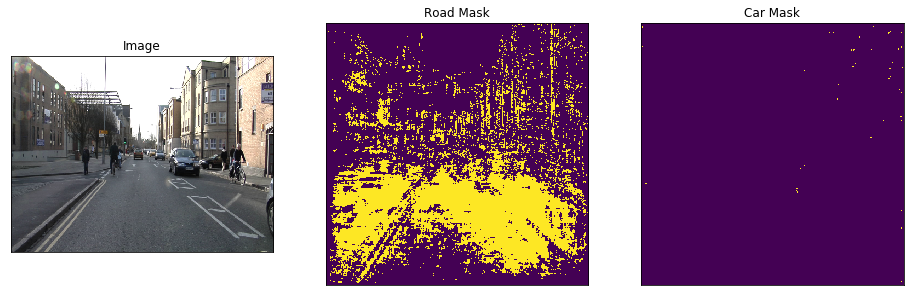

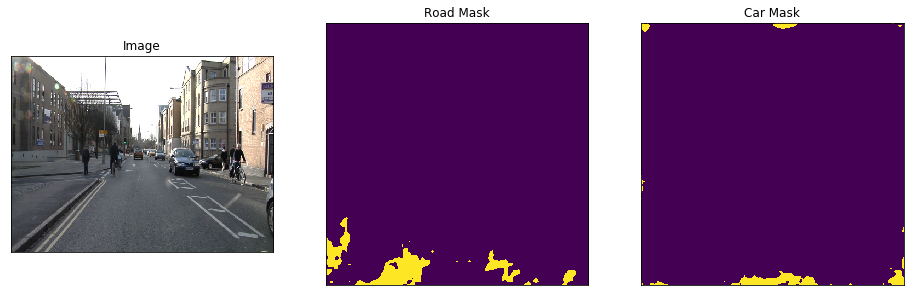

Labelled set size:  60
Unlabelled set size:  307

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:07<00:00, 12.90it/s, dice_loss - 0.5051, iou_score - 0.4221]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:07<00:00, 14.39it/s, dice_loss - 0.3061, iou_score - 0.5325]
Model saved!
IoU so far: 0.5324505060025961
Visualizing most uncertain results so far:


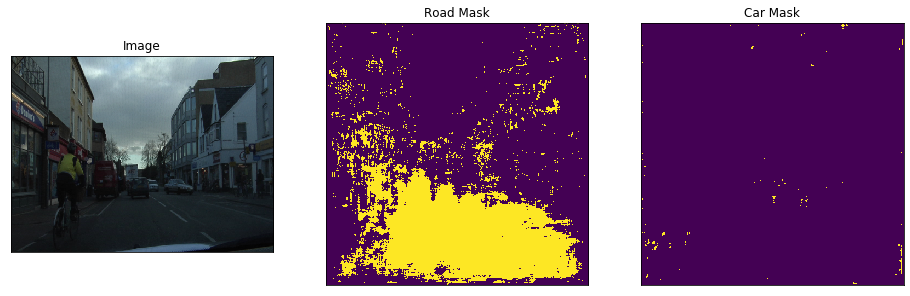

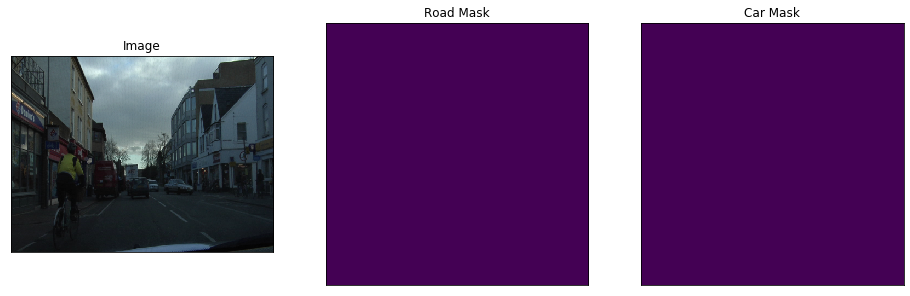

Labelled set size:  80
Unlabelled set size:  287

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:07<00:00, 13.30it/s, dice_loss - 0.4622, iou_score - 0.486]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:07<00:00, 14.10it/s, dice_loss - 0.3055, iou_score - 0.5325]
Model saved!
IoU so far: 0.5324609698635516
Visualizing most uncertain results so far:


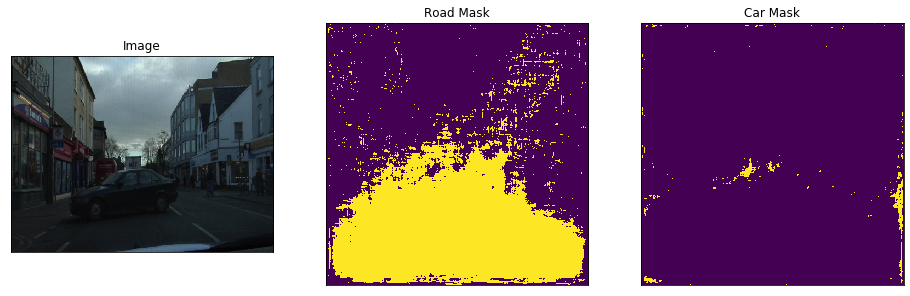

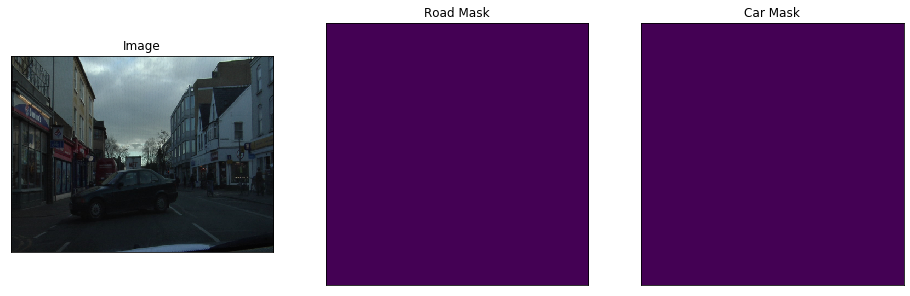

Labelled set size:  100
Unlabelled set size:  267

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:07<00:00, 13.32it/s, dice_loss - 0.3899, iou_score - 0.6582]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:07<00:00, 13.66it/s, dice_loss - 0.3055, iou_score - 0.5325]
Model saved!
IoU so far: 0.6581648192783393
Visualizing most uncertain results so far:


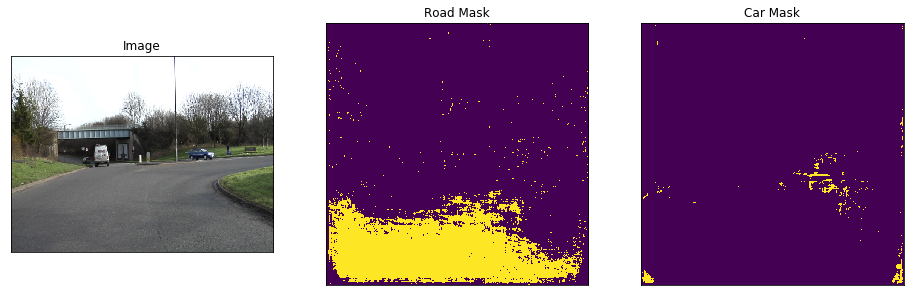

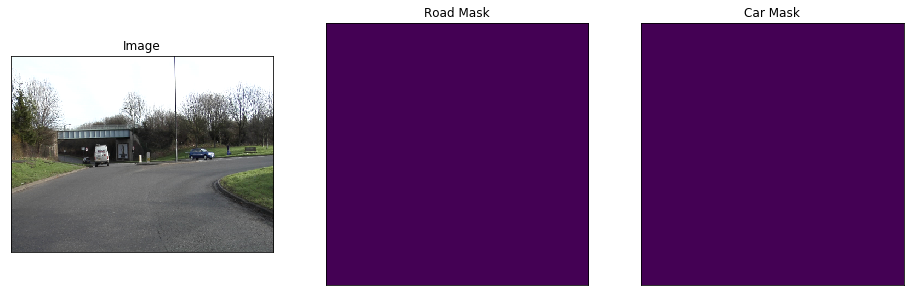

Max IoU score: 0.6581648192783393
----------------------------------------


Samples selection function: Committee
------------------------------------

Number of samples to label on one iteration, k=20
------------------------------------
Labelled set size:  20
Unlabelled set size:  347

Training a model for 1 epochs...
Creating new model: Unet_mobilenet_v2

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:07<00:00, 13.03it/s, dice_loss - 0.6554, iou_score - 0.04999]
Model saved!

Training a model for 1 epochs...
Creating new model: FPN_mobilenet_v2

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:07<00:00, 13.53it/s, dice_loss - 0.2084, iou_score - 0.7245]


  0%|          | 0/347 [00:00<?, ?it/s]

Model saved!
IoU so far: 0.7245048184205987
Inference on unlabelled data...


100%|██████████| 347/347 [01:07<00:00,  5.15it/s]


Min Vote entropy: 0.596,             Mean Vote entropy: 0.672,             Max Vote entropy: 0.764
Visualizing most uncertain results so far:


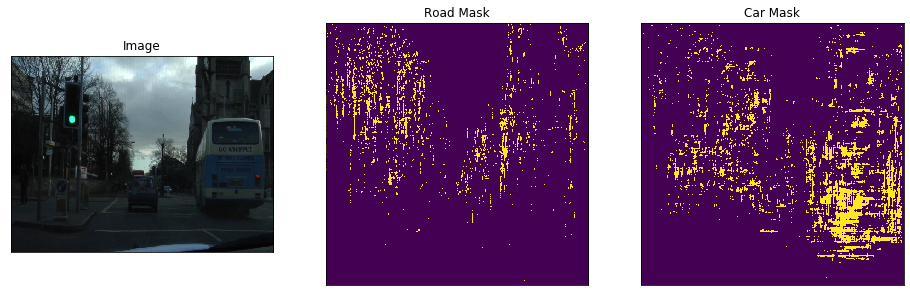

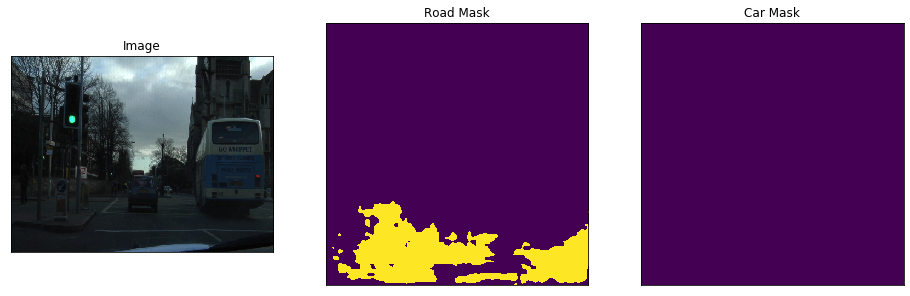

Labelled set size:  40
Unlabelled set size:  327

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:08<00:00, 12.41it/s, dice_loss - 0.6286, iou_score - 0.1228]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:06<00:00, 14.69it/s, dice_loss - 0.304, iou_score - 0.5325]


  0%|          | 0/327 [00:00<?, ?it/s]

Model saved!
IoU so far: 0.5324621477929673
Inference on unlabelled data...


100%|██████████| 327/327 [01:02<00:00,  5.21it/s]


Min Vote entropy: 0.486,             Mean Vote entropy: 0.619,             Max Vote entropy: 0.728
Visualizing most uncertain results so far:


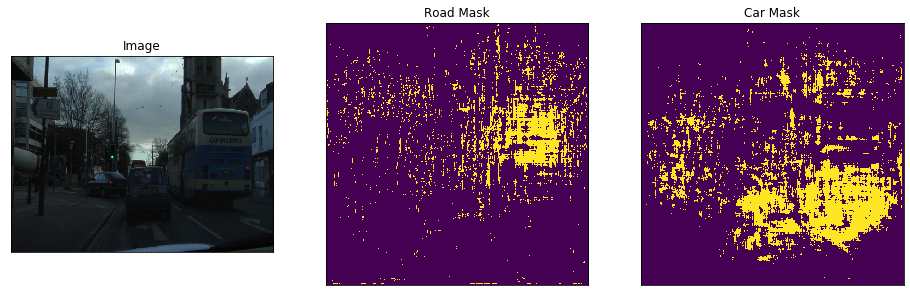

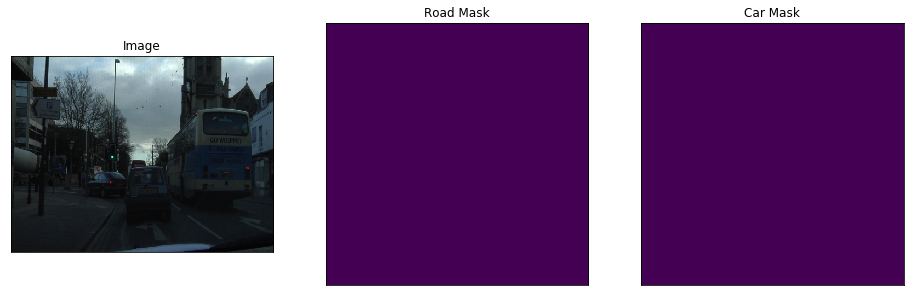

Labelled set size:  60
Unlabelled set size:  307

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:07<00:00, 12.90it/s, dice_loss - 0.572, iou_score - 0.2575]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:07<00:00, 14.17it/s, dice_loss - 0.3054, iou_score - 0.5325]


  0%|          | 0/307 [00:00<?, ?it/s]

Model saved!
IoU so far: 0.5324609698635516
Inference on unlabelled data...


100%|██████████| 307/307 [00:58<00:00,  5.24it/s]


Min Vote entropy: 0.335,             Mean Vote entropy: 0.536,             Max Vote entropy: 0.700
Visualizing most uncertain results so far:


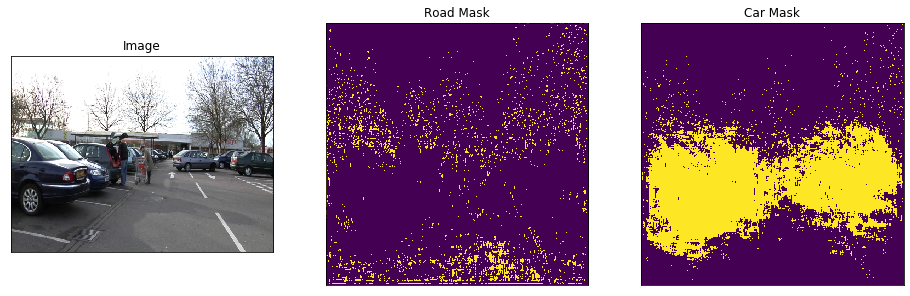

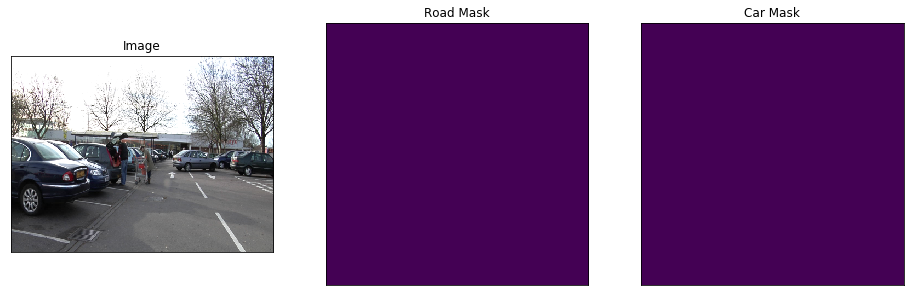

Labelled set size:  80
Unlabelled set size:  287

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:07<00:00, 14.04it/s, dice_loss - 0.5028, iou_score - 0.457]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:06<00:00, 15.21it/s, dice_loss - 0.3055, iou_score - 0.5325]
Model saved!


  0%|          | 0/287 [00:00<?, ?it/s]

IoU so far: 0.5324609698635516
Inference on unlabelled data...


100%|██████████| 287/287 [00:55<00:00,  5.15it/s]


Min Vote entropy: 0.245,             Mean Vote entropy: 0.426,             Max Vote entropy: 0.550
Visualizing most uncertain results so far:


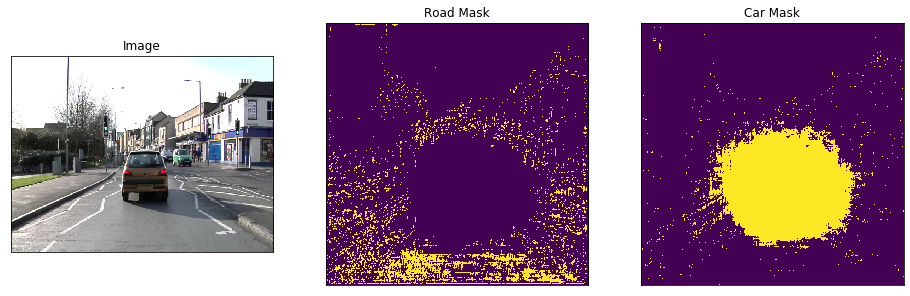

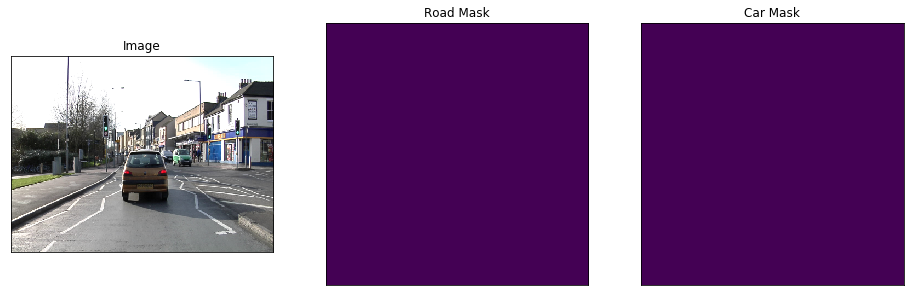

Labelled set size:  100
Unlabelled set size:  267

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:07<00:00, 14.28it/s, dice_loss - 0.4558, iou_score - 0.551]
Model saved!

Training a model for 1 epochs...

Epoch: 0 LR: [0.0001]
valid: 100%|██████████| 101/101 [00:06<00:00, 15.25it/s, dice_loss - 0.3055, iou_score - 0.5325]
Model saved!


  0%|          | 0/267 [00:00<?, ?it/s]

IoU so far: 0.5509869695299925
Inference on unlabelled data...


100%|██████████| 267/267 [00:50<00:00,  5.29it/s]


Min Vote entropy: 0.105,             Mean Vote entropy: 0.275,             Max Vote entropy: 0.403
Visualizing most uncertain results so far:


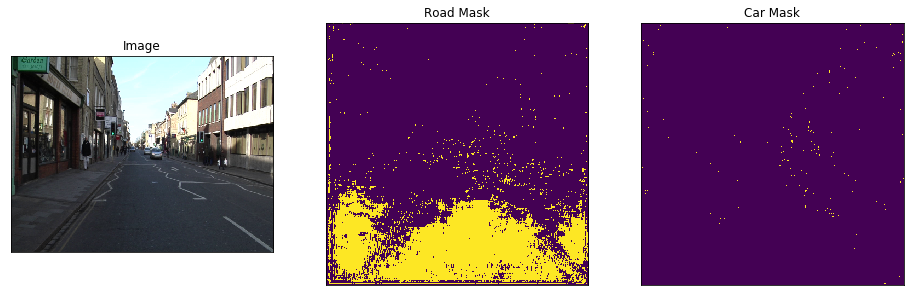

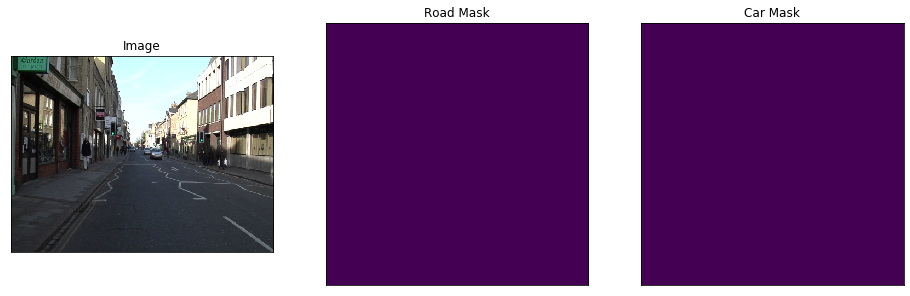

Max IoU score: 0.7245048184205987
----------------------------------------

saved results.pkl /home/ruslan/Desktop/DoEdu/src/active_learning/src/notebooks ['query_by_committee.ipynb', 'tb_runs', 'best_model.pth', '.ipynb_checkpoints', 'results.pkl']


In [5]:
results = {}

# choose samples selection function
for samples_selection_name in SAMPLES_SELECTIONS:
    print(f'\nSamples selection function: {samples_selection_name}')
    print('------------------------------------')
    results[samples_selection_name] = {}
    
    # choose number of samples to select for labelling from inference results
    for k in NUM_UNCERTAIN_IMAGES:
        print(f'\nNumber of samples to label on one iteration, k={k}')
        print('------------------------------------')

        # define models committee
        model1 = SegModel('Unet', encoder='mobilenet_v2', classes=SEMSEG_CLASSES)
        model2 = SegModel('FPN', encoder='mobilenet_v2', classes=SEMSEG_CLASSES)

        models = [model1, model2]
        for model in models:
            model.epochs = MODEL_TRAIN_EPOCHS
            model.batch_size = BATCH_SIZE
            model.learning_rate = INITIAL_LR
            
        results[samples_selection_name][str(k)] = {}

        experiment_name = f'{samples_selection_name}_{k}'
        IoUs, N_train_samples = al_experiment(models,
                                      k,
                                      samples_selection_name,
                                      experiment_name,
                                      visualize_most_uncertain=True,
                                      verbose_train=True)
        
        results[samples_selection_name][str(k)]['IoUs'] = IoUs
        results[samples_selection_name][str(k)]['N_train_samples'] = N_train_samples
        
pickle_save('results.pkl', results)

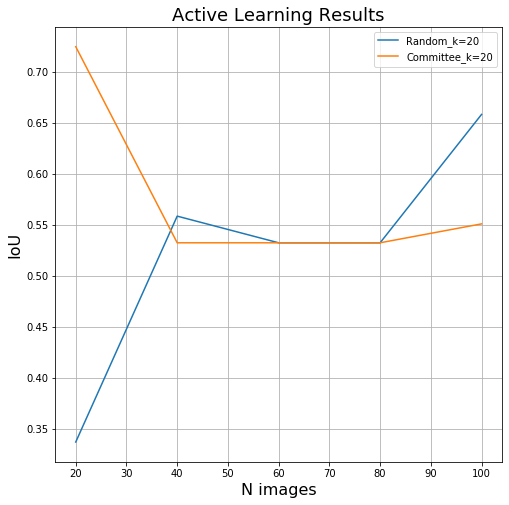

In [7]:
results = pickle_load('results.pkl')

plt.figure(figsize=(8,8))

# choose samples selection function
for samples_selection_name in SAMPLES_SELECTIONS:        
    # choose number of samples to select for labelling from inference results
    for k in NUM_UNCERTAIN_IMAGES:

        ious = results[samples_selection_name][str(k)]['IoUs']
        n_train = results[samples_selection_name][str(k)]['N_train_samples']
        
        plt.plot(np.array(n_train[1:]), ious[1:], label=f'{samples_selection_name}_k={k}')

plt.grid()
plt.title('Active Learning Results', fontsize=18)
plt.xlabel('N images', fontsize=16)
plt.ylabel('IoU', fontsize=16)
plt.legend();